In [1]:
import iminuit
%load_ext line_profiler
import matplotlib.pyplot as plt
%matplotlib inline
import numba
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
from scipy import optimize
import seaborn as sns
from theano.compile.ops import as_op
import theano.tensor as tt

sns.set_style('darkgrid')
sns.set_context('notebook')

In [2]:
def CI(M, p):
    value = M.values[p]
    lower = M.get_merrors()[p]['lower']
    upper = M.get_merrors()[p]['upper']
    return value + lower, value + upper

In [3]:
results = pd.DataFrame()

# Load C14 models

In [4]:
import c14_models

# Read patient data

In [5]:
c14_patient_data = pd.read_excel('data/C14data_liver_samples.xlsx')[['sort', 'Code', 'DOB', 'DOA', u'Δ 14C']]
c14_patient_data.columns = ['type', 'pub_id', 'Dbirth', 'Dcoll', 'd14C']
c14_patient_data['mass'] = 1.0
c14_patient_data['d14C'] /= 1000.0

In [6]:
exp_data = c14_patient_data.query('type == "hepatocyte"')
exp_data.describe()

,Dbirth,Dcoll,d14C,mass
count,19.000000,19.000000,19.000000,19.0
mean,1964.021930,2015.605263,0.043114,1.0
std,20.059938,3.810909,0.021048,0.0
min,1932.583333,2004.833333,0.017700,1.0
25%,1946.166667,2016.458333,0.027331,1.0
50%,1964.000000,2016.750000,0.039600,1.0
75%,1981.250000,2017.125000,0.051000,1.0
max,1995.333333,2017.416667,0.090351,1.0


# SSE & log-likelihood

In [7]:
def SSE(p, model, data):
    model_data = model(data['Dbirth'].values, 
                    data['Dcoll'].values, 
                    *p)
    sse = np.sum((model_data - data['d14C'].values)**2)
    return sse    

In [8]:
def Sigma(p, model, data):
    sse = SSE(p, model, data)
    n = len(data)
    sigma = np.sqrt(sse/n)
    return sigma

In [9]:
def Nloglike(p, model, data):
    try:
        sse = SSE(p, model, data)
    except:
        sse = SSE([p], model, data)
    n = len(data)
    sig = np.sqrt(sse/n)
    loglike = -n/2 * np.log(2*np.pi) - n/2 * np.log(sig**2) - 1 / (2*sig**2) * sse
    return -loglike

# Scenario I1

In [10]:
@np.vectorize
def I1(Dbirth, Dcoll, loglam):
    lam = np.exp(loglam)
    return c14_models.I1(Dbirth, Dcoll, lam, t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## Artifical data

In [11]:
lam = 0.1
n = 20
np.random.seed(42)
artifical_data = pd.DataFrame(
                    data={'Dbirth': 
                               np.random.uniform(1930, 1970, n), 
                          'Dcoll': 
                               np.random.uniform(2014, 2018, n)}
                             )

artifical_data['d14C'] = I1(artifical_data['Dbirth'], 
                            artifical_data['Dcoll'], 
                            loglam=np.log(lam)) 
artifical_data['d14C'] += np.random.normal(0, 0.01, 
                                           len(artifical_data)
                                          )

In [12]:
artifical_data.head()

,Dbirth,Dcoll,d14C
0,1944.981605,2016.447412,0.068665
1,1968.028572,2014.557975,0.072392
2,1959.279758,2015.168579,0.084824
3,1953.946339,2015.465447,0.062206
4,1936.240746,2015.824280,0.074498


### Parameter recovery

#### Brute force

In [13]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(np.log(0.01), np.log(10.0))],
                  args = (I1, artifical_data),
                  Ns = 10,
                  full_output = True,
                  finish=None)

In [14]:
lam = sp.exp(res[0])
print('lamda', lam)

sig = Sigma([np.log(lam)], I1, artifical_data)
print('sigma', sig)

lamda 0.1
sigma 0.00926419903019


#### Minuit

In [15]:
M_I1_test = iminuit.Minuit(lambda loglam: Nloglike([loglam], I1, artifical_data),
                          errordef=0.5,
                          loglam=np.log(1.1), error_loglam=0.01)
_ = M_I1_test.migrad()

FCN = -66.82552888478445 
 TOTAL NCALL = 78 
 NCALLS = 78 
 
 
 EDM = 0.00036614805524242175 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,loglam,-2.24995,0.000861099,0,0,,,


#### Pymc3

100%|██████████| 1000/1000 [06:01<00:00,  2.76it/s]


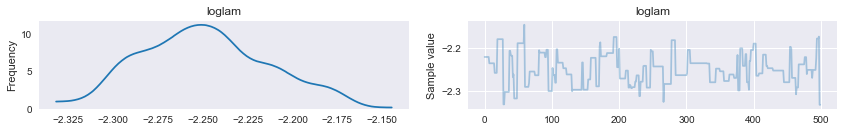

In [16]:
@as_op(itypes=[tt.dscalar], otypes=[tt.dvector])
def pmI1(loglam):
    lam = np.exp(loglam)
    c = np.empty_like(artifical_data['Dbirth'])
    
    for i, (Db, Dc) in enumerate(zip(artifical_data['Dbirth'], artifical_data['Dcoll'])):
        c[i] = c14_models.I1(Db, Dc, lam, t_eval=np.linspace(Db, Dc))[1][-1]
    return c

I1_model = pm.Model()

with I1_model:

    # Priors for unknown model parameters
    loglam = pm.Uniform('loglam', lower=np.log(0.05), upper=np.log(0.2))
    sigma = 0.01 #pm.HalfNormal('sigma', sd=1)

    # Expected value of outcome
    mu = pmI1(loglam)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=artifical_data['d14C'].values)

with I1_model:
    trace = pm.sample(step=pm.Metropolis())

_ = pm.traceplot(trace)